In [10]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ultralyticsplus import render_result
from ultralytics import YOLO

import paddleocr
from paddleocr import PaddleOCR, draw_ocr

import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from osgeo import ogr

## Importing Image ##

(4906, 3890, 3)


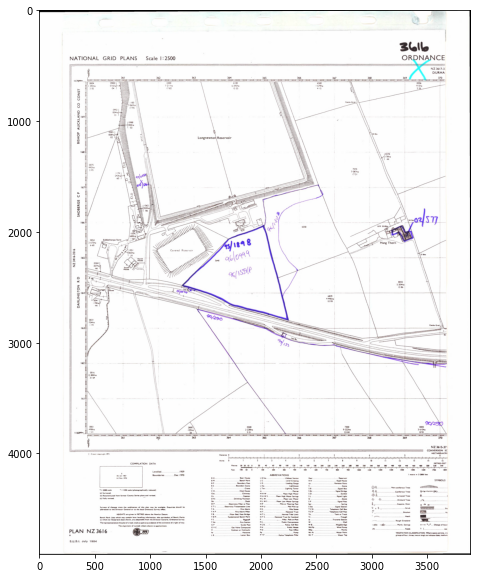

In [11]:
image_path = 'stockton_1.png'

img = cv2.imread(image_path)
print(img.shape) #1318 1045
plt.figure(figsize=(10,10))
plt.imshow(img)

## Object Detection and Segmentation using Deep Learning ##

In [12]:
model_path = 'runs/segment/train15/weights/last.pt'
model = YOLO(model_path)  # load a pretrained model (recommended for training)

In [13]:
results = model(image_path, save=True)

Ultralytics YOLOv8.0.43  Python-3.7.5 torch-1.13.1+cpu CPU
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 E:\PYTHON_PROJECTS\NOTEBOOKS\stockton_1.png: 640x512 7 land_markingss, 406.3ms
Speed: 0.0ms preprocess, 406.3ms inference, 31.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict14


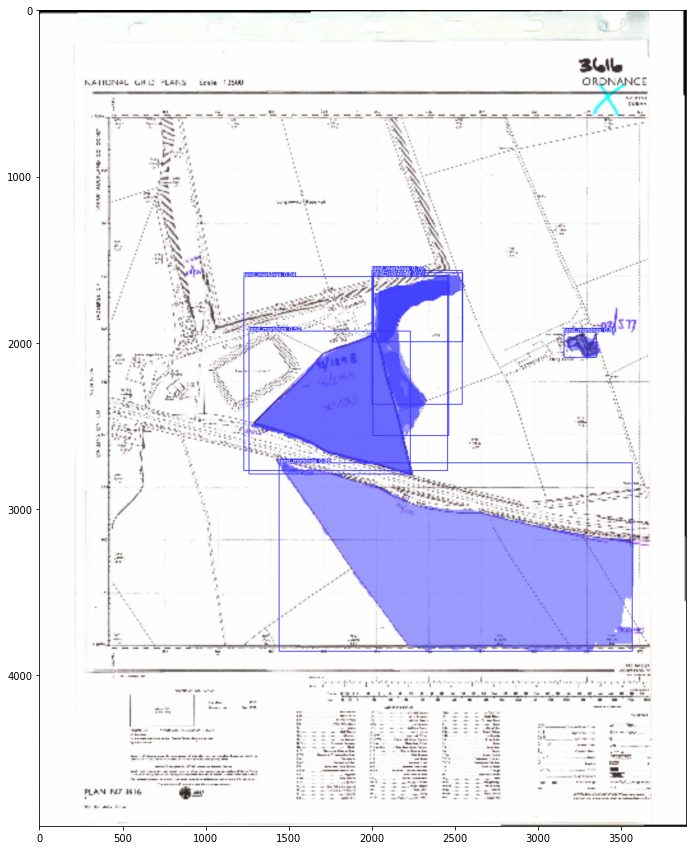

In [14]:
result_img = cv2.imread('runs/segment/predict/'+image_path)
plt.figure(figsize=(15,15))
plt.imshow(result_img)

## Image processing on Segmented land images ##

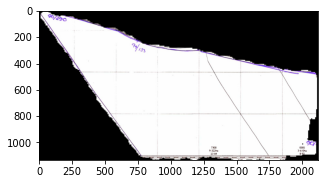

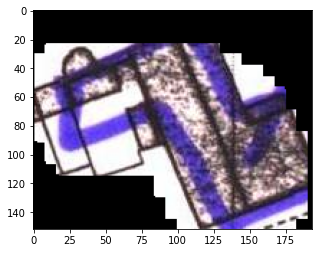

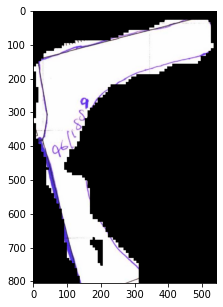

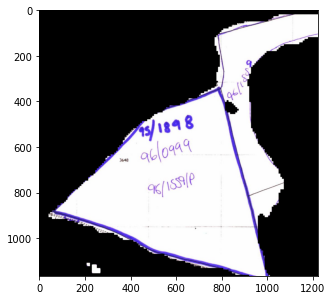

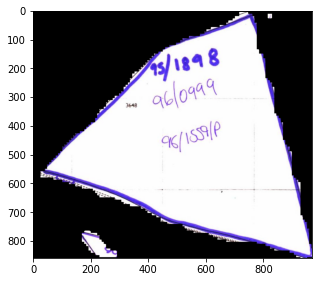

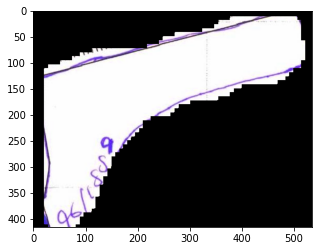

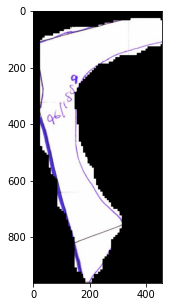

In [15]:
mask_list = []
coordinates_list = []
segmented_land_list = []

directory = 'segmented_land_images'
if not os.path.exists(directory):
    os.makedirs(directory)

i=0
for result in results:
    for mask, box in zip(result.masks.data , result.boxes.xyxy):
        mask = mask.numpy().astype(np.uint8) * 255
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        coordinates_list.append(np.argwhere(mask).tolist())
        mask_list.append(mask)
                                
        boxes = box.tolist()
        (x1,y1,x2,y2) = (int(boxes[0]), int(boxes[1]), int(boxes[2]), int(boxes[3]))
        masked = cv2.bitwise_and(img, img, mask=mask)
        segmented_land = masked[y1:y2, x1:x2]
        segmented_land_list.append(segmented_land)
        
        plt.figure(figsize=(5,5))
        plt.imshow(segmented_land)
        
        cv2.imwrite('./segmented_land_images/segmented_land'+str(i)+'.png', segmented_land)
        i+=1

## OCR for extracting reference numbers ##

[2025/07/09 20:46:26] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\SCC/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\SCC/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0

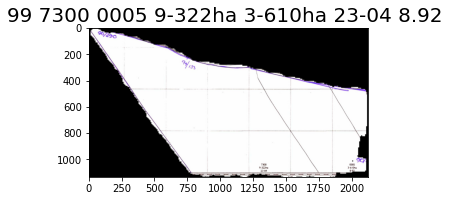

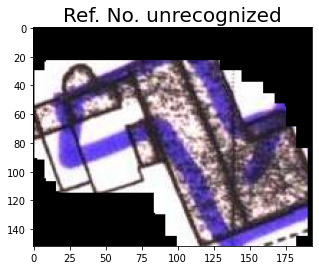

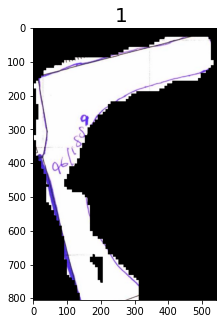

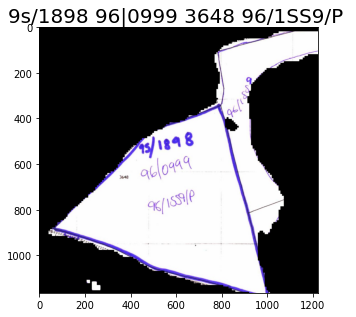

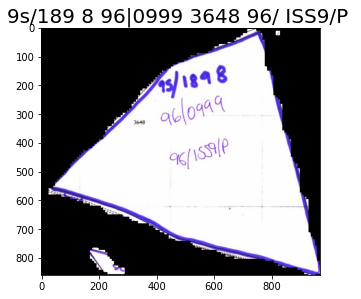

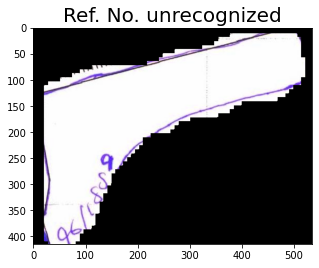

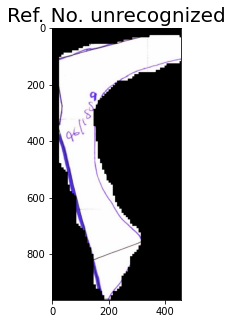

In [16]:
directory = 'reference_numbers'
if not os.path.exists(directory):
    os.makedirs(directory)
    
save_path = './reference_numbers/'

ocr = PaddleOCR(use_angle_cls=False, lang='en')
reference_numbers_list = []

for i in range(len(segmented_land_list)):
    image = cv2.cvtColor(segmented_land_list[i], cv2.COLOR_BGR2GRAY)
    result = ocr.ocr(segmented_land_list[i],cls=True)
        
    full_reference_num = ''
    if len(result[0])==0:
        full_reference_num = 'Ref. No. unrecognized'
    
    for item in result[0]:
        full_reference_num += str(item[-1][0]) + ' '
    reference_numbers_list.append(full_reference_num)
    
    file_name = 'reference_numbers'+str(i)+'.txt'
    file_path = os.path.join(save_path, file_name)         

    with open(file_path, 'w') as file:
        file.write(reference_numbers_list[i])
    
    plt.figure(figsize=(5,5))
    plt.title(reference_numbers_list[i], fontsize=20)
    plt.imshow(segmented_land_list[i])

## Creating Geopackage for extracted land segments ##

In [17]:
directory = 'geopackage_files'
if not os.path.exists(directory):
    os.makedirs(directory)
    
save_path = './geopackage_files/'

for i in range(len(coordinates_list)):
    polygon = Polygon(coordinates_list[i])
    gdf = gpd.GeoDataFrame(crs = {'init' :'epsg:4326'})
    gdf.loc[0,'name'] = 'land_marking'
    gdf.loc[0, 'geometry'] = polygon
    
    file_name = 'segmented_land'+str(i)+'.gpkg'
    file_path = os.path.join(save_path, file_name)         

    gdf.to_file(file_path, driver="GPKG")

## Including Reference numbers from OCR as metadata for Geopackage file ##

In [18]:
path = './geopackage_files/'

gpkg_list = list(glob.glob(path+'*.gpkg'))

for i in range(len(gpkg_list)):
    
    myfile = ogr.GetDriverByName('GPKG').Open(path+gpkg_list[i].split('\\')[-1], 1)
    reference_nums = {}

    #for i in range(len(reference_numbers_list)):
    reference_nums['Reference No. for segmented land'+str(i)] = str(reference_numbers_list[i])
    myfile.SetMetadata(reference_nums)

    myfile=None

    myfile = ogr.GetDriverByName('GPKG').Open(path+gpkg_list[i].split('\\')[-1], 1)
    print(myfile.GetMetadata() )
    
    myfile=None

{'Reference No. for segmented land0': '99 7300 0005 9-322ha 3-610ha 23-04 8.92 '}
{'Reference No. for segmented land1': 'Ref. No. unrecognized'}
{'Reference No. for segmented land2': '1 '}
{'Reference No. for segmented land3': '9s/1898 96|0999 3648 96/1SS9/P '}
{'Reference No. for segmented land4': '9s/189 8 96|0999 3648 96/ ISS9/P '}
{'Reference No. for segmented land5': 'Ref. No. unrecognized'}
{'Reference No. for segmented land6': 'Ref. No. unrecognized'}
